In [1]:
from paretoGraphTeams import *
import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import datasets
# IMDB
imdb_experts_1, imdb_tasks_1, imdb_costs_1, _ = import_pickled_datasets('imdb', 1)
imdb_experts_2, imdb_tasks_2, imdb_costs_2, _ = import_pickled_datasets('imdb', 2)
# imdb_experts_3, imdb_tasks_3, imdb_costs_3, _ = import_pickled_datasets('imdb', 3)

# Bibsonomy
bbsm_experts_1, bbsm_tasks_1, bbsm_costs_1, _ = import_pickled_datasets('bbsm', 1)
# bbsm_experts_2, bbsm_tasks_2, bbsm_costs_2, _ = import_pickled_datasets('bbsm', 2)

# Freelancer
fl_experts_1, fl_tasks_1, fl_costs_1, _ = import_pickled_datasets('freelancer', 1)
# fl_experts_2, fl_tasks_2, fl_costs_2, _ = import_pickled_datasets('freelancer', 2)

2026-02-01 13:11:54,250 |INFO: Imported imdb experts, Num Experts: 200
2026-02-01 13:11:54,251 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-01 13:11:54,252 |INFO: Imported imdb costs, Num Costs: 200
2026-02-01 13:11:54,256 |INFO: Imported imdb graph matrix, Shape: (1000, 1000)

2026-02-01 13:11:54,258 |INFO: Imported imdb experts, Num Experts: 400
2026-02-01 13:11:54,259 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-01 13:11:54,259 |INFO: Imported imdb costs, Num Costs: 400
2026-02-01 13:11:54,266 |INFO: Imported imdb graph matrix, Shape: (3000, 3000)

2026-02-01 13:11:54,268 |INFO: Imported bbsm experts, Num Experts: 250
2026-02-01 13:11:54,269 |INFO: Imported bbsm tasks, Num Tasks: 300
2026-02-01 13:11:54,270 |INFO: Imported bbsm costs, Num Costs: 250
2026-02-01 13:11:54,271 |INFO: Imported bbsm graph matrix, Shape: (500, 500)

2026-02-01 13:11:54,272 |INFO: Imported freelancer experts, Num Experts: 50
2026-02-01 13:11:54,273 |INFO: Imported freelancer tasks, Num Tasks: 25

In [2]:
def expertCoordinationAdjacencyMatrix(expert_list, use_jaccard=False):
    '''
    Create a coordination graph adjacency matrix of dimension len(expert_list)*len(expert_list) from a list of experts.
    If use_jaccard is True, the distance between two experts is the Jaccard distance.
    Otherwise, the distance between two experts is defined as 10*e^(-0.1*D) where D is the number of skills they have in common.
    '''
    n = len(expert_list)
    graphmat = np.zeros((n, n))
    for i in range(n):
        skills_i = set(expert_list[i])
        for j in range(n):
            if i != j:
                skills_j = set(expert_list[j])
                if use_jaccard:
                    union = skills_i | skills_j
                    if len(union) == 0:
                        graphmat[i, j] = 0.0
                    else:
                        inter = skills_i & skills_j
                        graphmat[i, j] = 1.0 - (len(inter) / len(union))
                else:
                    common_skills = len(skills_i & skills_j)
                    graphmat[i, j] = np.exp(-0.1 * common_skills)
    
    return graphmat

### Average Plotting across Tasks

In [3]:
def findApproximateParetoSolutions(tasks_list, experts_list, graphmat,
                                   sizeUniverse, numExperts, numTasks, maxDiameter,
                                   dataset_name=None, start_index=0):
    '''
    Run graph-diameter algorithm over multiple tasks, aggregate results, and plot mean +/- std.
    '''
    # Diameter grid (same for all tasks)
    num_steps, min_diameter = 15, 0.0
    diameter_arr = np.linspace(min_diameter, maxDiameter, num_steps)

    algo_names = ["ParetoGreedy-Diameter", "PlainGreedy", "TopK-degree", "PruneGraph"]

    def align_to_diameter_arr(diameters, covs):
        if len(diameters) == 0 or len(covs) == 0:
            return np.zeros_like(diameter_arr, dtype=float)
        diameters = np.array(diameters, dtype=float)
        covs = np.array(covs, dtype=float)

        # Ensure matching lengths
        min_len = min(len(diameters), len(covs))
        diameters = diameters[:min_len]
        covs = covs[:min_len]

        # Aggregate duplicate diameters by taking max coverage
        agg = {}
        for d, c in zip(diameters, covs):
            if d in agg:
                agg[d] = max(agg[d], c)
            else:
                agg[d] = c
        if len(agg) == 0:
            return np.zeros_like(diameter_arr, dtype=float)
        diameters_sorted = np.array(sorted(agg.keys()), dtype=float)
        covs_sorted = np.array([agg[d] for d in diameters_sorted], dtype=float)

        return np.interp(diameter_arr, diameters_sorted, covs_sorted, left=covs_sorted[0], right=covs_sorted[-1])

    # containers across tasks
    all_coverages = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_diams_all = []
    pareto_points_counts = []

    # iterate tasks
    for task_index in range(start_index, start_index + numTasks):
        # per-task containers
        task_coverages = {alg: [] for alg in algo_names}
        task_runtimes = {alg: [] for alg in algo_names}

        # Initialize Pareto teams object
        pareto_diam = paretoGraph(task=tasks_list[task_index],
                                  n_experts=experts_list[:numExperts],
                                  pairwise_costs=graphmat[:numExperts, :numExperts],
                                  size_univ=sizeUniverse,
                                  budget=1)

        diameters, best_coverages, _, _, runTime = pareto_diam.ParetoGreedyDiameter()
        diameters = np.array(diameters, dtype=float)

        # Interpolate to shared diameter grid
        task_coverages['ParetoGreedy-Diameter'] = list(align_to_diameter_arr(diameters, best_coverages))
        task_runtimes['ParetoGreedy-Diameter'].append(runTime)
        pareto_diams_all.extend(diameters)
        pareto_points_counts.append(len(diameters))

        # Plain Greedy (distance-scaled) baseline
        pg_diam, pg_covs, _, _, pg_time = pareto_diam.plainGreedyDistanceScaled()
        task_coverages['PlainGreedy'] = list(align_to_diameter_arr(pg_diam, pg_covs))
        task_runtimes['PlainGreedy'].append(pg_time)

        # Top-K (distance-scaled) baseline
        tk_diam, tk_covs, _, _, tk_time = pareto_diam.topKDistanceScaled()
        task_coverages['TopK-degree'] = list(align_to_diameter_arr(tk_diam, tk_covs))
        task_runtimes['TopK-degree'].append(tk_time)

        # Graph pruning baseline (already returns diameters)
        pr_radii, pr_coverages, _, _, pr_time = pareto_diam.graphPruning()
        pr_diameters = np.array(pr_radii, dtype=float)
        task_coverages['PruneGraph'] = list(align_to_diameter_arr(pr_diameters, pr_coverages))
        task_runtimes['PruneGraph'].append(pr_time)

        # convert per-task lists to numpy arrays and store in all_coverages
        for alg in algo_names:
            arr = np.array(task_coverages[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(diameter_arr, dtype=float)
            all_coverages[alg].append(arr)
            runtimes = task_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    # compute mean and std across tasks for each algorithm
    mean_coverages = {}
    std_coverages = {}
    for alg in algo_names:
        stacked = np.vstack(all_coverages[alg])  # shape (numTasks, len(diameter_arr))
        mean_coverages[alg] = np.mean(stacked, axis=0)
        std_coverages[alg] = np.std(stacked, axis=0)*0.5

    mean_pareto_points = int(np.round(np.mean(pareto_points_counts))) if len(pareto_points_counts) > 0 else 0
    if mean_pareto_points < 1:
        mean_pareto_points = 1

    # Plot mean coverage with shaded std band
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3,1,1,1))]
    markers = ['o', 's', '^', 'v', 'D']
    color_map = {
        "PlainGreedy": colors[0],
        "PruneGraph": colors[2],
        "TopK-degree": colors[4],
        "ParetoGreedy-Diameter": colors[3],
    }
    marker_map = {
        "PlainGreedy": "o",
        "PruneGraph": "^",
        "TopK-degree": "D",
        "ParetoGreedy-Diameter": "D",
    }
    plot_order = ["PlainGreedy", "PruneGraph", "TopK-degree", "ParetoGreedy-Diameter"]
    legend_order = ["ParetoGreedy-Diameter", "PlainGreedy", "PruneGraph", "TopK-degree"]

    fig, ax = plt.subplots(figsize=(9, 5.5))
    label_map = {}
    pareto_legend_handle = None
    for i, alg in enumerate(plot_order):
        mean = mean_coverages[alg]
        std = std_coverages[alg]*0.5
        is_pareto = alg == "ParetoGreedy-Diameter"
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'

        color = color_map.get(alg, colors[i])
        marker = marker_map.get(alg, markers[i % len(markers)])
        zorder = 4 if is_pareto else 3
        if is_pareto:
            marker = "D"

        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        label_map[alg] = label
        if is_pareto:
            ax.plot(diameter_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            pareto_diams_unique = np.unique(np.array(pareto_diams_all, dtype=float))
            pareto_diams_unique = pareto_diams_unique[(pareto_diams_unique >= diameter_arr.min()) & (pareto_diams_unique <= diameter_arr.max())]
            pareto_mean_vals = np.interp(pareto_diams_unique, diameter_arr, mean)
            ax.scatter(pareto_diams_unique, pareto_mean_vals,
                       label="_nolegend_",
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
            from matplotlib.lines import Line2D
            pareto_legend_handle = Line2D([0], [0],
                                          color=color,
                                          linestyle=line_style,
                                          marker=marker,
                                          markersize=marker_size,
                                          markeredgewidth=1.1,
                                          markeredgecolor='k',
                                          linewidth=1.8)
        else:
            ax.plot(diameter_arr, mean,
                    label=label,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=1.1,
                    markeredgecolor='k',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(diameter_arr,
                        np.clip(mean - std, 0, 1),
                        np.clip(mean + std, 0, 1),
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Team diameter, $c_d$', fontsize=28)
    ax.set_ylabel(r'Task coverage, $\bar{f}$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        handle_map = dict(zip(labels, handles))
        pareto_label = label_map.get("ParetoGreedy-Diameter")
        if pareto_label and pareto_legend_handle is not None:
            handle_map[pareto_label] = pareto_legend_handle
        ordered_labels = []
        if pareto_label:
            ordered_labels.append(pareto_label)
        ordered_labels.extend([label_map[alg] for alg in legend_order if alg != "ParetoGreedy-Diameter"])
        ordered_handles = [handle_map[l] for l in ordered_labels if l in handle_map]

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "graph"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_graph.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "graph_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(ordered_handles, ordered_labels, loc='center', ncol=2, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)

    plt.show()

    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))

## Freelancer-1

2026-02-01 13:11:54,382 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[26, 42, 22, 44], Num Experts:50, Budget=1
2026-02-01 13:11:54,386 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.002s
2026-02-01 13:11:54,389 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.002s
2026-02-01 13:11:54,393 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.003s
2026-02-01 13:11:54,414 |INFO: GraphPruning finished: max_coverage=1.000, runtime=0.019s
2026-02-01 13:11:54,415 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[35, 45, 28, 13], Num Experts:50, Budget=1
2026-02-01 13:11:54,419 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.003s
2026-02-01 13:11:54,423 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.004s
2026-02-01 13:11:54,429 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.005s
2026-02-01 13:11:54,449 |INFO: GraphPruning finished: max

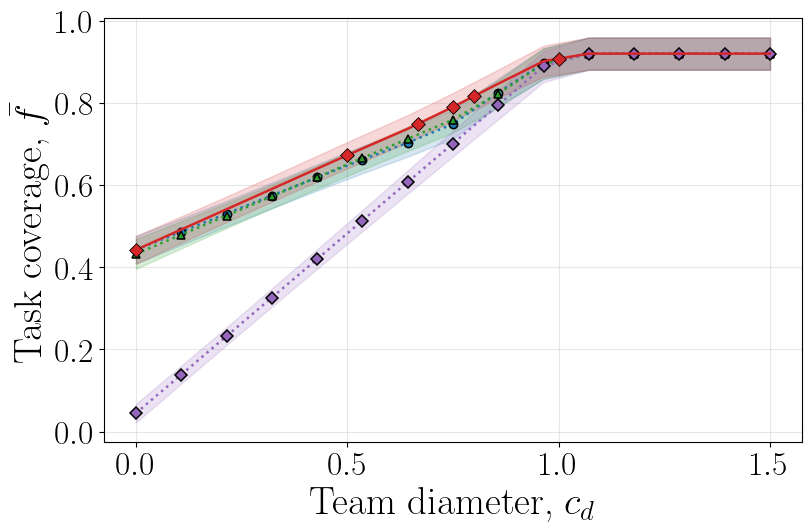

2026-02-01 13:11:55,988 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Diameter: 0.003 ± 0.001
  - PlainGreedy: 0.009 ± 0.012
  - TopK-degree: 0.004 ± 0.001
  - PruneGraph: 0.020 ± 0.003


In [4]:
fl_graphmat_1 = expertCoordinationAdjacencyMatrix(fl_experts_1[:50], use_jaccard=True)
findApproximateParetoSolutions(tasks_list=fl_tasks_1, experts_list=fl_experts_1, graphmat=fl_graphmat_1,
                               sizeUniverse=50, numExperts=50, numTasks=20,
                               maxDiameter=1.5 * np.max(fl_graphmat_1),
                               dataset_name="Freelancer")

## IMDB

2026-02-01 13:11:56,097 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7], Num Experts:150, Budget=1
2026-02-01 13:11:56,108 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.010s
2026-02-01 13:11:56,116 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.007s
2026-02-01 13:11:56,131 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.014s
2026-02-01 13:11:56,320 |INFO: GraphPruning finished: max_coverage=1.000, runtime=0.189s
2026-02-01 13:11:56,321 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[1, 3, 4, 6, 8], Num Experts:150, Budget=1
2026-02-01 13:11:56,330 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.008s
2026-02-01 13:11:56,334 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.003s
2026-02-01 13:11:56,349 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.014s
2026-02-01 13:11:56,540 |INFO: GraphPruning fini

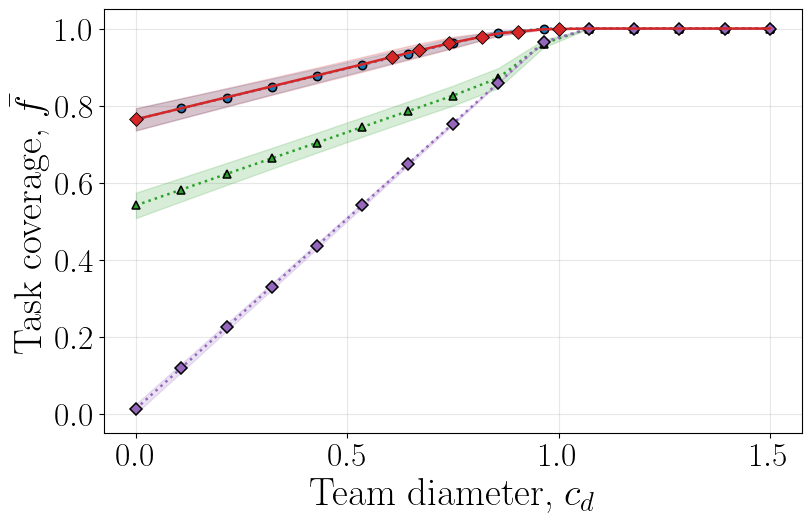

2026-02-01 13:12:02,841 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Diameter: 0.007 ± 0.003
  - PlainGreedy: 0.003 ± 0.001
  - TopK-degree: 0.017 ± 0.011
  - PruneGraph: 0.185 ± 0.007


In [5]:
imdb_graphmat_1 = expertCoordinationAdjacencyMatrix(imdb_experts_1[:150])
findApproximateParetoSolutions(tasks_list=imdb_tasks_1, experts_list=imdb_experts_1, graphmat=imdb_graphmat_1,
                               sizeUniverse=24, numExperts=150, numTasks=30,
                               maxDiameter=1.5 * np.max(imdb_graphmat_1),
                               dataset_name="IMDB-1")

2026-02-01 13:12:03,084 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7, 8], Num Experts:300, Budget=1
2026-02-01 13:12:03,099 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.014s
2026-02-01 13:12:03,112 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.012s
2026-02-01 13:12:03,180 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.067s
2026-02-01 13:12:04,197 |INFO: GraphPruning finished: max_coverage=1.000, runtime=1.016s
2026-02-01 13:12:04,199 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[0, 5, 9, 10, 11], Num Experts:300, Budget=1
2026-02-01 13:12:04,219 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.019s
2026-02-01 13:12:04,249 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.029s
2026-02-01 13:12:04,331 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.071s
2026-02-01 13:12:05,330 |INFO: GraphPruning

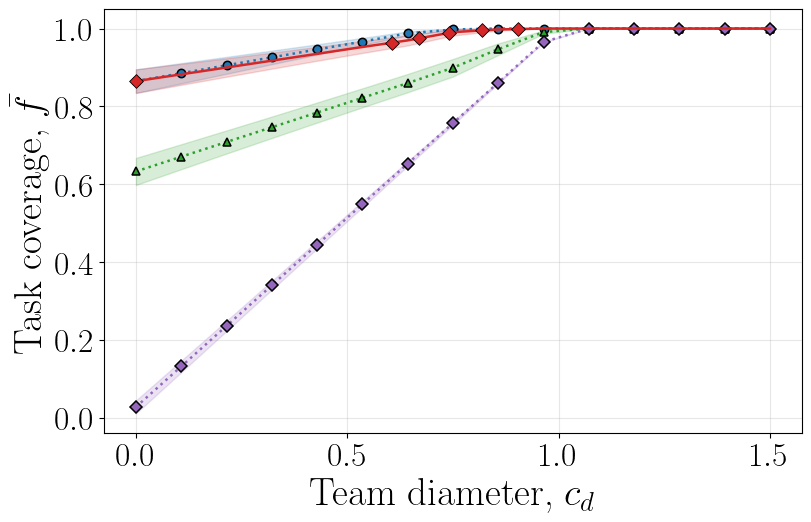

2026-02-01 13:12:35,876 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Diameter: 0.014 ± 0.009
  - PlainGreedy: 0.005 ± 0.006
  - TopK-degree: 0.066 ± 0.011
  - PruneGraph: 0.994 ± 0.020


In [6]:
imdb_graphmat_2 = expertCoordinationAdjacencyMatrix(imdb_experts_2[:300])
findApproximateParetoSolutions(tasks_list=imdb_tasks_2, experts_list=imdb_experts_2, graphmat=imdb_graphmat_2,
                               sizeUniverse=24, numExperts=300, numTasks=30,
                               maxDiameter=1.5 * np.max(imdb_graphmat_2),
                               dataset_name="IMDB-2")

## Bbsm-1

2026-02-01 13:12:36,079 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[67, 51, 4, 52], Num Experts:250, Budget=1
2026-02-01 13:12:36,097 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.017s
2026-02-01 13:12:36,099 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.001s
2026-02-01 13:12:36,144 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.045s
2026-02-01 13:12:36,792 |INFO: GraphPruning finished: max_coverage=1.000, runtime=0.647s
2026-02-01 13:12:36,793 |INFO: Initialized Pareto Coverage - Graph Cost Instance, Task:[65, 1, 70, 51, 22, 56], Num Experts:250, Budget=1
2026-02-01 13:12:36,801 |INFO: GreedyThresholdDiameter finished: max_coverage=1.000, runtime=0.007s
2026-02-01 13:12:36,807 |INFO: PlainGreedyDistanceScaled finished: max_coverage=1.000, runtime=0.005s
2026-02-01 13:12:36,847 |INFO: TopKDistanceScaled finished: max_coverage=1.000, runtime=0.040s
2026-02-01 13:12:37,619 |INFO: GraphPruning finis

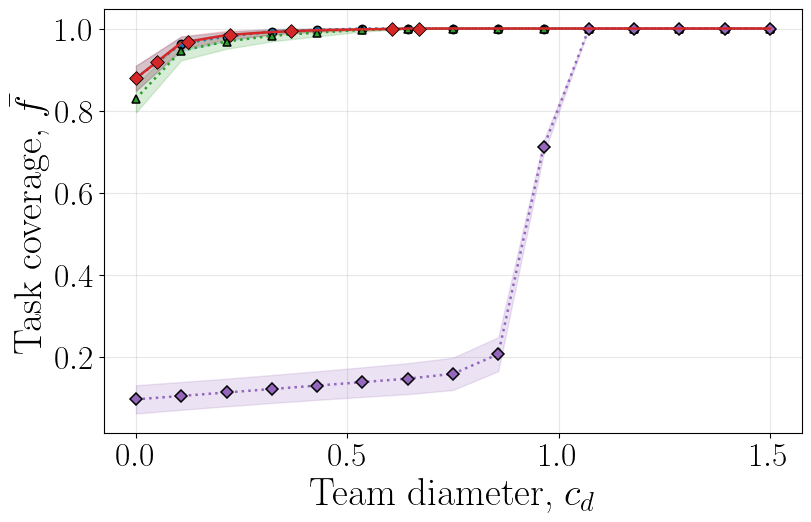

2026-02-01 13:12:57,778 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Diameter: 0.008 ± 0.003
  - PlainGreedy: 0.003 ± 0.003
  - TopK-degree: 0.042 ± 0.006
  - PruneGraph: 0.657 ± 0.030


In [7]:
bbsm_graphmat_1 = expertCoordinationAdjacencyMatrix(bbsm_experts_1[:250])
findApproximateParetoSolutions(tasks_list=bbsm_tasks_1, experts_list=bbsm_experts_1, graphmat=bbsm_graphmat_1,
                               sizeUniverse=75, numExperts=250, numTasks=30,
                               maxDiameter=1.5 * np.max(bbsm_graphmat_1),
                               dataset_name="Bbsm")